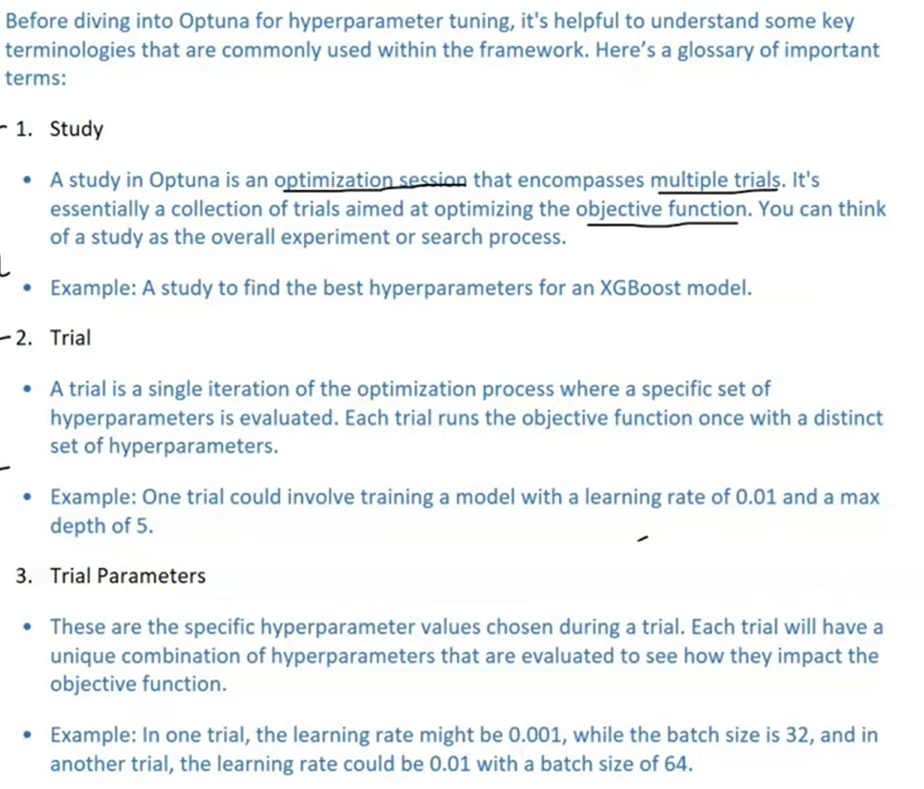

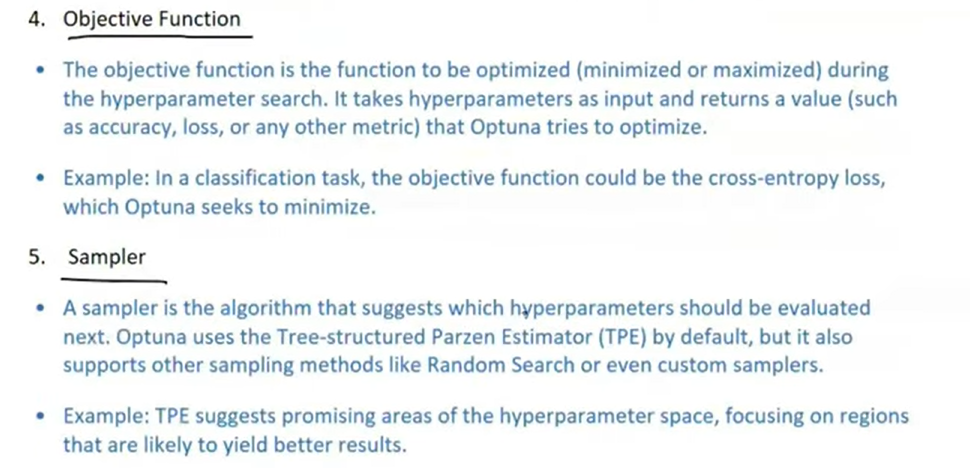

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.1 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import optuna
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the Pima Indian Diabetes dataset from sklearn
# Note: Scikit-learn's built-in 'load_diabetes' is a regression dataset.
# We will load the actual diabetes dataset from an external source
import pandas as pd

# Load the Pima Indian Diabetes dataset (from UCI repository)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
           'DiabetesPedigreeFunction', 'Age', 'Outcome']

# Load the dataset
df = pd.read_csv(url, names=columns)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
import numpy as np

# Replace zero values with NaN in columns where zero is not a valid value
cols_with_missing_vals = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_missing_vals] = df[cols_with_missing_vals].replace(0, np.nan)

# Impute the missing values with the mean of the respective column
df.fillna(df.mean(), inplace=True)

# Check if there are any remaining missing values
print(df.isnull().sum())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [4]:
# Split into features (X) and target (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optional: Scale the data for better model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shape of the data
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')


Training set shape: (537, 8)
Test set shape: (231, 8)


# TPE Sampler

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)

    # Create the RandomForestClassifier with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    # Perform 3-fold cross-validation and calculate accuracy
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

    return score  # Return the accuracy score for Optuna to maximize


In [6]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials to find the best hyperparameters


[I 2025-08-23 10:15:08,985] A new study created in memory with name: no-name-3fd193bf-c230-4812-a57a-e106f475ea07
[I 2025-08-23 10:15:09,808] Trial 0 finished with value: 0.7690875232774674 and parameters: {'n_estimators': 166, 'max_depth': 10}. Best is trial 0 with value: 0.7690875232774674.
[I 2025-08-23 10:15:10,954] Trial 1 finished with value: 0.7709497206703911 and parameters: {'n_estimators': 182, 'max_depth': 15}. Best is trial 1 with value: 0.7709497206703911.
[I 2025-08-23 10:15:11,405] Trial 2 finished with value: 0.7709497206703911 and parameters: {'n_estimators': 58, 'max_depth': 17}. Best is trial 1 with value: 0.7709497206703911.
[I 2025-08-23 10:15:12,027] Trial 3 finished with value: 0.7616387337057727 and parameters: {'n_estimators': 92, 'max_depth': 4}. Best is trial 1 with value: 0.7709497206703911.
[I 2025-08-23 10:15:12,463] Trial 4 finished with value: 0.7728119180633147 and parameters: {'n_estimators': 68, 'max_depth': 7}. Best is trial 4 with value: 0.772811918

In [7]:

# Print the best result
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.7783985102420857
Best hyperparameters: {'n_estimators': 178, 'max_depth': 16}


In [8]:
from sklearn.metrics import accuracy_score

# Train a RandomForestClassifier using the best hyperparameters from Optuna
best_model = RandomForestClassifier(**study.best_trial.params, random_state=42)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print the test accuracy
print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')


Test Accuracy with best hyperparameters: 0.74


# Random Sampler

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)

    # Create the RandomForestClassifier with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    # Perform 3-fold cross-validation and calculate accuracy
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

    return score  # Return the accuracy score for Optuna to maximize


In [10]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials to find the best hyperparameters

[I 2025-08-23 10:16:16,615] A new study created in memory with name: no-name-3dd4a356-48d6-4c53-af72-cc8ff546b26e
[I 2025-08-23 10:16:17,016] Trial 0 finished with value: 0.7616387337057727 and parameters: {'n_estimators': 85, 'max_depth': 8}. Best is trial 0 with value: 0.7616387337057727.
[I 2025-08-23 10:16:17,859] Trial 1 finished with value: 0.7597765363128491 and parameters: {'n_estimators': 194, 'max_depth': 4}. Best is trial 0 with value: 0.7616387337057727.
[I 2025-08-23 10:16:18,574] Trial 2 finished with value: 0.7690875232774674 and parameters: {'n_estimators': 147, 'max_depth': 18}. Best is trial 2 with value: 0.7690875232774674.
[I 2025-08-23 10:16:19,337] Trial 3 finished with value: 0.7690875232774674 and parameters: {'n_estimators': 161, 'max_depth': 10}. Best is trial 2 with value: 0.7690875232774674.
[I 2025-08-23 10:16:19,852] Trial 4 finished with value: 0.7616387337057727 and parameters: {'n_estimators': 110, 'max_depth': 6}. Best is trial 2 with value: 0.76908752

In [11]:

# Print the best result
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.7802607076350093
Best hyperparameters: {'n_estimators': 123, 'max_depth': 17}


In [13]:
from sklearn.metrics import accuracy_score

# Train a RandomForestClassifier using the best hyperparameters from Optuna
best_model = RandomForestClassifier(**study.best_trial.params, random_state=42)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print the test accuracy
print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')


Test Accuracy with best hyperparameters: 0.74


# Grid Sampler

In [14]:
search_space = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20]
}

In [15]:
# Create a study and optimize it using GridSampler
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective)

[I 2025-08-23 10:17:50,726] A new study created in memory with name: no-name-5da3c7e2-c660-404d-8f3c-5dfc8cb9d701
[I 2025-08-23 10:17:51,185] Trial 0 finished with value: 0.7690875232774674 and parameters: {'n_estimators': 100, 'max_depth': 5}. Best is trial 0 with value: 0.7690875232774674.
[I 2025-08-23 10:17:51,927] Trial 1 finished with value: 0.7672253258845437 and parameters: {'n_estimators': 150, 'max_depth': 10}. Best is trial 0 with value: 0.7690875232774674.
[I 2025-08-23 10:17:52,177] Trial 2 finished with value: 0.7728119180633147 and parameters: {'n_estimators': 50, 'max_depth': 15}. Best is trial 2 with value: 0.7728119180633147.
[I 2025-08-23 10:17:52,688] Trial 3 finished with value: 0.7653631284916201 and parameters: {'n_estimators': 100, 'max_depth': 15}. Best is trial 2 with value: 0.7728119180633147.
[I 2025-08-23 10:17:53,209] Trial 4 finished with value: 0.7690875232774674 and parameters: {'n_estimators': 100, 'max_depth': 20}. Best is trial 2 with value: 0.772811

In [16]:

# Print the best result
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.7746741154562384
Best hyperparameters: {'n_estimators': 50, 'max_depth': 5}


In [17]:
from sklearn.metrics import accuracy_score

# Train a RandomForestClassifier using the best hyperparameters from Optuna
best_model = RandomForestClassifier(**study.best_trial.params, random_state=42)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print the test accuracy
print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')


Test Accuracy with best hyperparameters: 0.74


# Optuna Visualizations

In [18]:
# For visualizations
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_contour, plot_param_importances

### 1. Optimization History

In [19]:
plot_optimization_history(study).show()

### 2. Parallel Coordinates Plot

In [20]:
plot_parallel_coordinate(study).show()

### 3. Slice Plot

In [21]:
plot_slice(study).show()

### 4. Contour Plot

In [22]:
plot_contour(study).show()

### 5. Hyperparameter Importance

In [23]:
plot_param_importances(study).show()

## Optimizing Multiple ML Models

In [24]:
# Importing the required libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [25]:
# Define the objective function for Optuna
def objective(trial):
    # Choose the algorithm to tune
    classifier_name = trial.suggest_categorical('classifier', ['SVM', 'RandomForest', 'GradientBoosting'])

    if classifier_name == 'SVM':
        # SVM hyperparameters
        c = trial.suggest_float('C', 0.1, 100, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

        model = SVC(C=c, kernel=kernel, gamma=gamma, random_state=42)

    elif classifier_name == 'RandomForest':
        # Random Forest hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42
        )

    elif classifier_name == 'GradientBoosting':
        # Gradient Boosting hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

    # Perform cross-validation and return the mean accuracy
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

In [26]:
# Create a study and optimize it using CmaEsSampler
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-08-23 10:25:50,811] A new study created in memory with name: no-name-c8f10a1c-2556-4e50-960c-5432438c7166
[I 2025-08-23 10:25:51,420] Trial 0 finished with value: 0.7746741154562384 and parameters: {'classifier': 'RandomForest', 'n_estimators': 97, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.7746741154562384.
[I 2025-08-23 10:25:54,787] Trial 1 finished with value: 0.7486033519553073 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 197, 'learning_rate': 0.025255538736296344, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7746741154562384.
[I 2025-08-23 10:25:56,616] Trial 2 finished with value: 0.7523277467411545 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 166, 'learning_rate': 0.030797081908903894, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7746741154562384.
[I 2025-08

In [27]:
# Retrieve the best trial
best_trial = study.best_trial
print("Best trial parameters:", best_trial.params)
print("Best trial accuracy:", best_trial.value)

Best trial parameters: {'classifier': 'SVM', 'C': 0.14494075697342987, 'kernel': 'linear', 'gamma': 'auto'}
Best trial accuracy: 0.7895716945996275


In [28]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_C,params_bootstrap,params_classifier,params_gamma,params_kernel,params_learning_rate,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
0,0,0.774674,2025-08-23 10:25:50.813596,2025-08-23 10:25:51.420223,0 days 00:00:00.606627,NaN,False,RandomForest,NaN,NaN,NaN,10.0,3.0,8.0,97.0,COMPLETE
1,1,0.748603,2025-08-23 10:25:51.422812,2025-08-23 10:25:54.787153,0 days 00:00:03.364341,NaN,NaN,GradientBoosting,NaN,NaN,0.025256,20.0,4.0,9.0,197.0,COMPLETE
2,2,0.752328,2025-08-23 10:25:54.787961,2025-08-23 10:25:56.616928,0 days 00:00:01.828967,NaN,NaN,GradientBoosting,NaN,NaN,0.030797,16.0,7.0,6.0,166.0,COMPLETE
3,3,0.737430,2025-08-23 10:25:56.617712,2025-08-23 10:25:57.305932,0 days 00:00:00.688220,NaN,NaN,GradientBoosting,NaN,NaN,0.034415,9.0,5.0,3.0,59.0,COMPLETE
4,4,0.769088,2025-08-23 10:25:57.306663,2025-08-23 10:25:58.635213,0 days 00:00:01.328550,NaN,True,RandomForest,NaN,NaN,NaN,15.0,5.0,5.0,293.0,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.774674,2025-08-23 10:26:22.341209,2025-08-23 10:26:22.373673,0 days 00:00:00.032464,0.148131,NaN,SVM,auto,sigmoid,NaN,NaN,NaN,NaN,NaN,COMPLETE
96,96,0.785847,2025-08-23 10:26:22.374139,2025-08-23 10:26:22.397806,0 days 00:00:00.023667,0.232177,NaN,SVM,scale,linear,NaN,NaN,NaN,NaN,NaN,COMPLETE
97,97,0.757914,2025-08-23 10:26:22.398323,2025-08-23 10:26:23.193278,0 days 00:00:00.794955,NaN,NaN,GradientBoosting,NaN,NaN,0.067977,19.0,9.0,4.0,80.0,COMPLETE
98,98,0.767225,2025-08-23 10:26:23.194080,2025-08-23 10:26:23.222820,0 days 00:00:00.028740,0.361415,NaN,SVM,auto,rbf,NaN,NaN,NaN,NaN,NaN,COMPLETE


In [29]:
study.trials_dataframe()['params_classifier'].value_counts()

,count
params_classifier,
SVM,75
RandomForest,14
GradientBoosting,11


In [30]:
study.trials_dataframe().groupby('params_classifier')['value'].mean()

,value
params_classifier,
GradientBoosting,0.751481
RandomForest,0.767624
SVM,0.776983


In [31]:
# 1. Optimization History
plot_optimization_history(study).show()

In [32]:
# 2. Slice Plot
plot_slice(study).show()